<a href="https://colab.research.google.com/github/kkimlee/TensorFlow/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0%20%EA%B0%9C%EB%85%90%20%EA%B3%B5%EB%B6%80/Eager_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설치와 기본 사용법



In [17]:
import tensorflow as tf
import cProfile

텐서플로우 2.0이상 버전부터는 즉시 실행이 기본으로 활성화되어 있음

In [18]:
tf.executing_eagerly()

True

세션없이 텐서플로 연산을 실행할 수 있고, 결과 확인이 가능함

In [19]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


NumPy와 같이 작동함  
NumPy 배열을 tf.Tensor 객체로 변환하여 tf.Tensor.numpy 메서드를 이용해 객체 값을 NumPy ndarray로 반환

In [20]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [21]:
# 브로드캐스팅
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [22]:
# 연산자 오버로딩
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [23]:
# NumPy값 사용
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [24]:
# Tensor를 numpy 값으로 변환
print(a.numpy())

[[1 2]
 [3 4]]


# 동적인 제어

즉시 실행을 통해 모델이 실행되는 동안에도 동적인 제어가 가능함

In [25]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [26]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


# 그래디언트 계산

실행 중에 그래디언트를 계산하고 이용하기 위해 tf.GradientTape을 이용할 수 있음    

실행 중에 모든 연산은 tape에 저장되며, tape을 거꾸로 연산하여 그래디언트를 계산 한 후 tape은 사라짐  
  
tf.GradientTape은 오직 하나의 그래디언트만을 계산할 수 있고 추가적인 호출은 실행중 에러(runtime error)를 발생시킴

In [27]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


# 모델 훈련

MNIST 모델 훈련

In [28]:
# mnist 데이터 가져오기 및 포맷 맞추기
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32),
     tf.cast(mnist_labels, tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [29]:
# 모델 생성
mnist_model = tf.keras.Sequential([
                                   tf.keras.layers.Conv2D(16, [3,3], activation='relu',
                                                          input_shape=(None, None, 1)),
                                   tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dense(10)
])

즉시 실행에선 훈련을 하지 않아도 모델을 이용하여 결과를 보는 것이 가능함

In [30]:
for images, labels in dataset.take(1):
  print("로짓: ", mnist_model(images[0:1]).numpy())

로짓:  [[-0.01146818  0.02123119  0.03987922 -0.02694891 -0.01532512  0.02203199
   0.03039968  0.03189754 -0.00503749  0.02261385]]


케라스는 자체적으로 fit을 통해 훈련이 가능하지만, 다음과 같이 수정하여 훈련시킬수 있음

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []


In [45]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)

    # 결과의 형태를 확인하기 위해 추가
    tf.debugging.assert_equal(logits.shape, (32, 10))

    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [46]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print('epchos {} ends'.format(epoch))

In [47]:
train()

epchos 0 ends
epchos 1 ends
epchos 2 ends


Text(0, 0.5, 'Loss [entropy]')

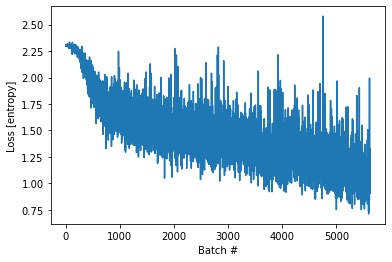

In [48]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

# 변수와 옵티마이저

tf.Variable 객체는 자동 미분을 쉽게 하기 위해 학습동안 변경된 tf.Tensor 값을 저장함.

모델의 파라미터를 캡슐화하기 위해 tf.Variable을 tf.GradientTape과 함께 사용

In [50]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

# 약 3 * x + 2개의 점으로 구성된 실험 데이터
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 최적화할 손실함수
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

# 정의:
# 1. 모델
# 2. 모델 파라미터에 대한 손실 함수의 미분
# 3. 미분에 기초한 변수 업데이트 전략
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("초기 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 반복 훈련
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("스텝 {:03d}에서 손실: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("최종 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))


초기 손실: 69.130
스텝 000에서 손실: 66.444
스텝 020에서 손실: 30.279
스텝 040에서 손실: 14.104
스텝 060에서 손실: 6.869
스텝 080에서 손실: 3.633
스텝 100에서 손실: 2.185
스텝 120에서 손실: 1.537
스텝 140에서 손실: 1.247
스텝 160에서 손실: 1.117
스텝 180에서 손실: 1.059
스텝 200에서 손실: 1.033
스텝 220에서 손실: 1.021
스텝 240에서 손실: 1.016
스텝 260에서 손실: 1.014
스텝 280에서 손실: 1.013
최종 손실: 1.012
W = 3.0002715587615967, B = 1.994046926498413


# 즉시 실행에서 상태를 위한 객체 사용

텐서플로 1.x에서는 변수의 수명은 tf.Session 객체에 의해 관리됨. 2.x 이상 버전에서는 객체의 수명은 그와 관련된 파이썬 객체 수명에 의해서 결정됨

## 변수 객체

2.x 이상 버전에서 변수는 객체의 마지막 참조가 제거될 때까지 유지되고 그 이후 삭제됨

In [51]:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("gpu:0"):
    print("GPU 사용 가능")
    v = tf.Variable(tf.random.normal([1000, 1000]))
    v = None # v가 더이상 아무것도 참조하지 않기 때문에 GPU 메모리를 사용하지 않음

## 객체 기반의 저장

훈련 체크포인트 저장

tf.train.Checkpoint는 tf.Variable을 체크포인트 파일로 저장하거나 체크포인트 파일에서 복구할 수 있음

In [52]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [53]:
x.assign(2.) # assign을 통해 변수에 새로운 값을 할당
checkpoint_path = './ckpt'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [54]:
x.assign(11.)

# 체크포인트를 이용하여 값을 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


옵티마이저와 모델, 전역 단게 상태를 기록하기 위해서 tf.train.Checkpoint에 전달하면 됨

In [55]:
import os

model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(16, [3, 3], activation='relu'),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 객체 지향형 지표

tf.keras.metrics는 객체로 저장됨. 데이터를 이 객체에 전달하여 지표를 수정하고, tf.keras.metrics.result 메서드를 이용하여 결과를 얻을 수 있음

In [56]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
m.result() # -> 2.5
m([8, 9])
m.result() # -> 5.5

<tf.Tensor: shape=(), dtype=float32, numpy=5.5>

## 서머리와 텐서보드

텐서보드는 훈련과정에서 모델을 파악하거나 디버깅, 최적화하기위해 사용되는 시각화 도구.

서머리 정보를 기록하는데 tf.summary가 사용됨. 다음 코드에선 매 100번째 훈련마다 loss의 서머리 정보를 기록함

In [57]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

with writer.as_default():  # 또는 반복 전에 writer.set_as_default()를 호출
  for i in range(1000):
    step = i + 1
    # 실제 훈련 함수로 손실을 계산
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('손실', loss, step=step)

In [60]:
ls tb/

events.out.tfevents.1617692851.5bd5d86571ae.59.637024.v2
